<a href="https://colab.research.google.com/github/shahendae/CreditCard-Fraud-Detection/blob/master/CreditCardFraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install PyDrive and authenticate user to access Google Drive and download dataset.**


---



In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [0]:
file_id = '1WH3KmO5X56aXHRojCQ47pH3a18oj1r5e'

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request, chunksize = 100 * 1024 * 1024)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

**Import and variables**


---



In [0]:
!pip install -q imblearn
!pip install -q seaborn
import imblearn.combine as imbcom
import imblearn.over_sampling as overs
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sb
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve

STRWIDTH = 30


**Read & describe the downloaded data using Pandas**


---



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115

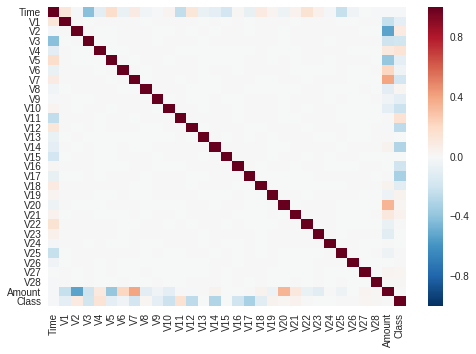

Features aren't correlated to each other



In [0]:
import matplotlib.gridspec as gridspec
original_data = pd.read_csv(io.StringIO(downloaded.getvalue().decode('utf-8')))

print(original_data.head())
print(original_data.describe())
print(original_data.shape)

data_correlaction = original_data.corr()
sb.heatmap(data_correlaction)
plt.show()

print("Features aren't correlated to each other")
print('')


**Determine important features**

In [0]:
X = original_data.iloc[:,1:29]
y = original_data.iloc[:,30]
rf = RandomForestClassifier()
rf.fit(X, y)

feature_importance = pd.DataFrame(rf.feature_importances_, index = X.columns, columns=['Importance']).sort_values('Importance', ascending=False)

In [0]:
print(feature_importance)

     Importance
V17    0.146578
V12    0.135151
V11    0.121161
V10    0.109304
V14    0.108565
V9     0.046856
V7     0.029028
V4     0.025267
V16    0.022846
V18    0.022337
V21    0.022012
V27    0.019020
V26    0.017121
V20    0.016916
V1     0.015498
V28    0.015356
V8     0.013727
V13    0.013655
V6     0.012991
V15    0.011920
V5     0.011620
V3     0.010507
V19    0.010267
V25    0.010143
V22    0.009642
V24    0.008676
V23    0.007102
V2     0.006733


**Method to balance the data using SMOTE then Tomek Links**


---



In [0]:
def balance_data(data):
    """Given an imbalanced dataset this method balances the data first using SMOTE (Synthetic Minority Over-sampling
    Technique) and then apply Tomek links (Undersampling)
    :param data: Original imbalanced dataset
    :return:
            x_new: Array containing the new resampled data.
            y_new: Array containing the corresponding labels for x_new
    """
    smote = imbcom.SMOTETomek()
    x = data.iloc[:, data.columns != 'Class']
    y = data.iloc[:, data.columns == 'Class']

    # Fit and resample the data directly
    x_new, y_new = smote.fit_sample(x, y.values.ravel())

    print(f'==================={str.center("ORIGINAL DATA", STRWIDTH)}===================')
    print(f'Total samples in the original dataset: {x.shape[0]}')
    original_fraud = len(data[data.Class == 1])
    print(f'Fraud in the original dataset: {original_fraud}')
    print(f'Percentage of fraud in original dataset {100*(original_fraud/x.shape[0])}%')
    pd.value_counts(y['Class']).plot(kind="bar")
    plt.show()

    print(f'==================={str.center("SAMPLED DATA", STRWIDTH)}===================')
    print(f'Total samples in the sampled data: {x_new.shape[0]}')
    sampled_fraud = len(y_new[y_new == 1])
    print(f'Fraud in sampled data: {sampled_fraud}')
    print(f'Percentage of fraud in sample data: {100*(sampled_fraud/x_new.shape[0])}%')
    y_new = pd.DataFrame(y_new, columns=['Class'])
    x_new = pd.DataFrame(x_new, columns=x.columns)

    pd.value_counts(y_new['Class']).plot(kind="bar")
    plt.show()

    return x_new, y_new


**Method to balance the data using UnderSampler**


In [0]:
def underSample(data):
    
    random_sampler = RandomUnderSampler()
    x = data.iloc[:, data.columns != 'Class']
    y = data.iloc[:, data.columns == 'Class']

    # Fit and resample the data directly
    x_new, y_new = random_sampler.fit_sample(x, y.values.ravel())

    print(f'==================={str.center("ORIGINAL DATA", STRWIDTH)}===================')
    print(f'Total samples in the original dataset: {x.shape[0]}')
    original_fraud = len(data[data.Class == 1])
    print(f'Fraud in the original dataset: {original_fraud}')
    print(f'Percentage of fraud in original dataset {100*(original_fraud/x.shape[0])}%')
    pd.value_counts(y['Class']).plot(kind="bar")
    plt.show()

    print(f'==================={str.center("SAMPLED DATA", STRWIDTH)}===================')
    print(f'Total samples in the sampled data: {x_new.shape[0]}')
    sampled_fraud = len(y_new[y_new == 1])
    print(f'Fraud in sampled data: {sampled_fraud}')
    print(f'Percentage of fraud in sample data: {100*(sampled_fraud/x_new.shape[0])}%')
    y_new = pd.DataFrame(y_new, columns=['Class'])
    x_new = pd.DataFrame(x_new, columns=x.columns)

    pd.value_counts(y_new['Class']).plot(kind="bar")
    plt.show()

    return x_new, y_new


**Normalizing the amount column (To reduce its weight while learning) & splitting the data**


---



In [0]:
original_data['Normalized_Amount'] = StandardScaler().fit_transform(original_data['Amount'].values.reshape(-1, 1))
original_data = original_data.drop(['Time', 'Amount','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8'], axis=1)
print(original_data.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V9       V10       V11       V12       V14       V16       V17  \
0  0.363787  0.090794 -0.551600 -0.617801 -0.311169 -0.470401  0.207971   
1 -0.255425 -0.166974  1.612727  1.065235 -0.143772  0.463917 -0.114805   
2 -1.514654  0.207643  0.624501  0.066084 -0.165946 -2.890083  1.109969   
3 -1.387024 -0.054952 -0.226487  0.178228 -0.287924 -1.059647 -0.684093   
4  0.817739  0.753074 -0.822843  0.538196 -1.119670 -0.451449 -0.237033   

        V18       V19       V21  Class  Normalized_Amount  
0  0.025791  0.403993 -0.018307      0

Testing data:
# Class 0 (Legit): 85294
# Class 1 (Fraud): 148
===================        ORIGINAL DATA         ===================
Total samples in the original dataset: 199365
Fraud in the original dataset: 344
Percentage of fraud in original dataset 0.17254783939006343%


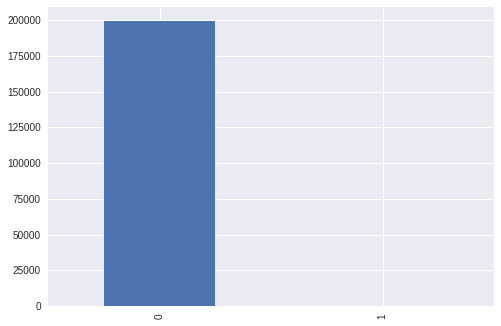

===================         SAMPLED DATA         ===================
Total samples in the sampled data: 398042
Fraud in sampled data: 199021
Percentage of fraud in sample data: 50.0%


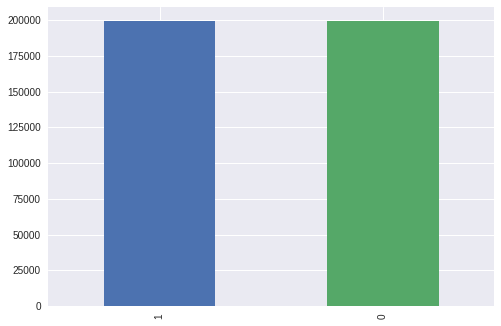

===================        ORIGINAL DATA         ===================
Total samples in the original dataset: 199365
Fraud in the original dataset: 344
Percentage of fraud in original dataset 0.17254783939006343%


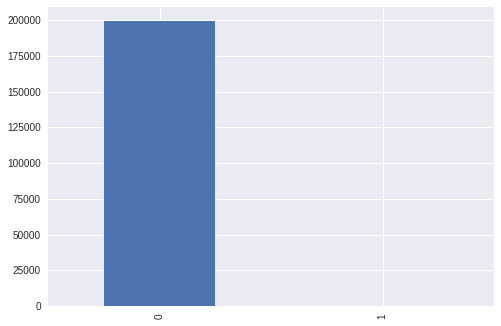

===================         SAMPLED DATA         ===================
Total samples in the sampled data: 688
Fraud in sampled data: 344
Percentage of fraud in sample data: 50.0%


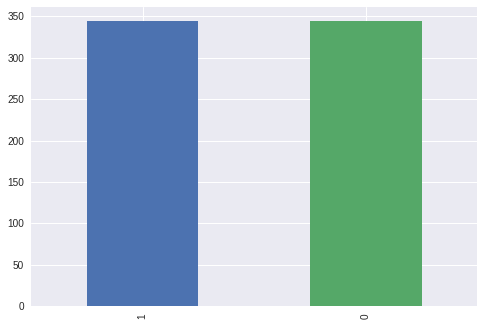

In [0]:
# Splitting data into test and train

#SMOTETomek

data = original_data.copy()

test_data = data[data.Class == 0].sample(frac=0.3)
test_data = pd.concat([test_data, data[data.Class == 1].sample(frac=0.3)])

# Untouched test data.

x_test = test_data.iloc[:, test_data.columns != 'Class']
y_test = test_data.iloc[:, test_data.columns == 'Class']

print("Testing data:")
print(f"# Class 0 (Legit): {len(test_data[test_data.Class == 0])}")
print(f"# Class 1 (Fraud): {len(test_data[test_data.Class == 1])}")

train_data = data.drop(test_data.index)

# SMOTETomek
sampled_train_data = balance_data(train_data.copy())
# Undersampling
underSampled_train_data = underSample(train_data.copy())

x_train_undersampled = underSampled_train_data[0]
y_train_undersampled = underSampled_train_data[1]

x_train = sampled_train_data[0]
y_train = sampled_train_data[1]

**A method to apply random forest algorithm on the train data, predict on train data and calculate accuracy**



---



In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score


def random_forest(X_train, X_test, y_train, y_test, n):

    rf = RandomForestClassifier(n_estimators=n, random_state=0, n_jobs=-1)
    rf.fit(X_train, y_train.values.ravel())
    prediction = rf.predict(X_test)
    accuracy = accuracy_score(y_test.values.ravel(), prediction)

    print(f'Mean accuracy score: {accuracy}')
    print("Precision: %1.3f" % precision_score(y_test, prediction))
    print("Recall: %1.3f" % recall_score(y_test, prediction))
    print("Classification Report: ")
    print(classification_report(y_test, prediction, target_names=['Class 0', 'Class 1']))
    # This should match the f1 score for class 1 in the classification report.
    print("F1: %1.3f\n" % f1_score(y_test, prediction))

    cm = pd.DataFrame(confusion_matrix(y_test, prediction))
    sb.heatmap(cm, annot=True)
    plt.show()

Number of trees:  50
Using SMOTETomek sampling: 
Mean accuracy score: 0.999520142318766
Precision: 0.902
Recall: 0.811
Classification Report: 
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00     85294
    Class 1       0.90      0.81      0.85       148

avg / total       1.00      1.00      1.00     85442

F1: 0.854



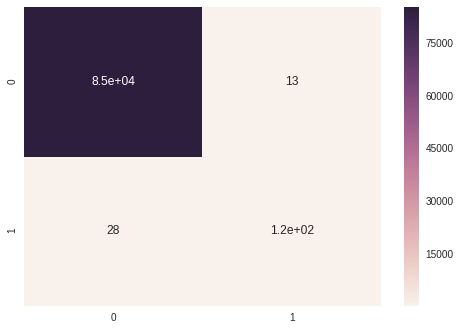

Using Undersampling: 
Mean accuracy score: 0.9630041431614429
Precision: 0.041
Recall: 0.899
Classification Report: 
             precision    recall  f1-score   support

    Class 0       1.00      0.96      0.98     85294
    Class 1       0.04      0.90      0.08       148

avg / total       1.00      0.96      0.98     85442

F1: 0.078



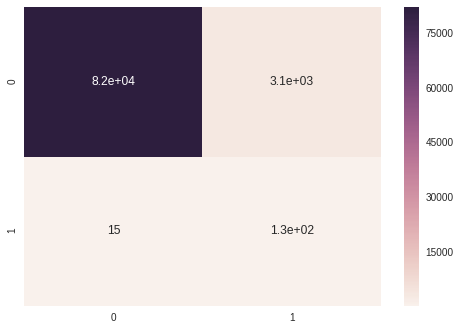

Number of trees:  100
Using SMOTETomek sampling: 
Mean accuracy score: 0.999520142318766
Precision: 0.902
Recall: 0.811
Classification Report: 
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00     85294
    Class 1       0.90      0.81      0.85       148

avg / total       1.00      1.00      1.00     85442

F1: 0.854



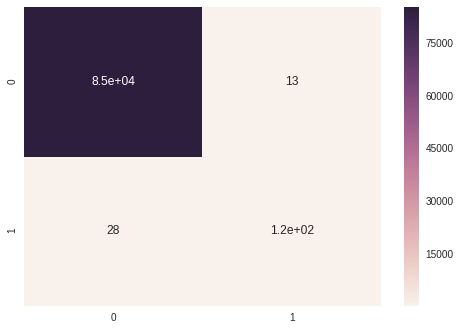

Using Undersampling: 
Mean accuracy score: 0.9657662507900096
Precision: 0.044
Recall: 0.899
Classification Report: 
             precision    recall  f1-score   support

    Class 0       1.00      0.97      0.98     85294
    Class 1       0.04      0.90      0.08       148

avg / total       1.00      0.97      0.98     85442

F1: 0.083



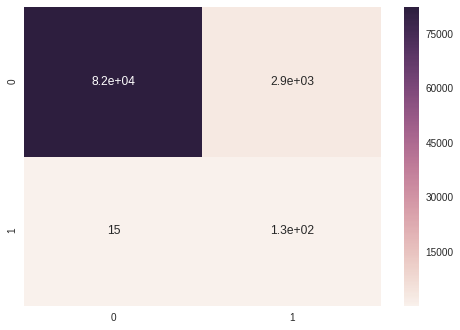

Number of trees:  150
Using SMOTETomek sampling: 
Mean accuracy score: 0.999520142318766
Precision: 0.902
Recall: 0.811
Classification Report: 
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00     85294
    Class 1       0.90      0.81      0.85       148

avg / total       1.00      1.00      1.00     85442

F1: 0.854



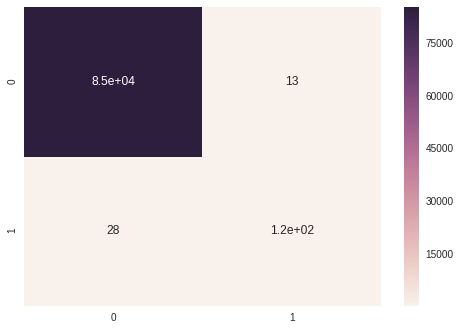

Using Undersampling: 
Mean accuracy score: 0.966901523840734
Precision: 0.045
Recall: 0.905
Classification Report: 
             precision    recall  f1-score   support

    Class 0       1.00      0.97      0.98     85294
    Class 1       0.05      0.91      0.09       148

avg / total       1.00      0.97      0.98     85442

F1: 0.087



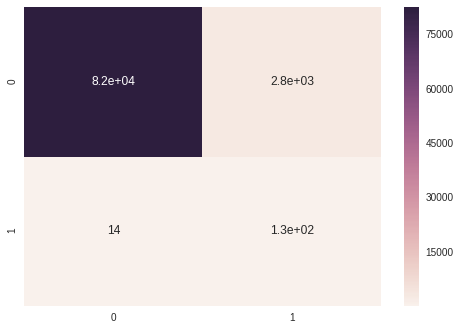

Number of trees:  250
Using SMOTETomek sampling: 
Mean accuracy score: 0.999520142318766
Precision: 0.902
Recall: 0.811
Classification Report: 
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00     85294
    Class 1       0.90      0.81      0.85       148

avg / total       1.00      1.00      1.00     85442

F1: 0.854



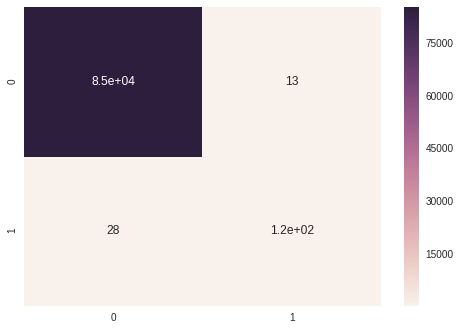

Using Undersampling: 
Mean accuracy score: 0.9680602045832261
Precision: 0.047
Recall: 0.905
Classification Report: 
             precision    recall  f1-score   support

    Class 0       1.00      0.97      0.98     85294
    Class 1       0.05      0.91      0.09       148

avg / total       1.00      0.97      0.98     85442

F1: 0.089



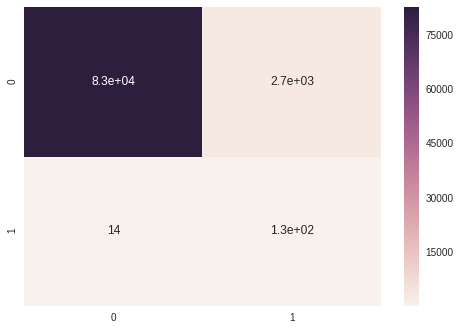

Number of trees:  300
Using SMOTETomek sampling: 
Mean accuracy score: 0.999520142318766
Precision: 0.902
Recall: 0.811
Classification Report: 
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00     85294
    Class 1       0.90      0.81      0.85       148

avg / total       1.00      1.00      1.00     85442

F1: 0.854



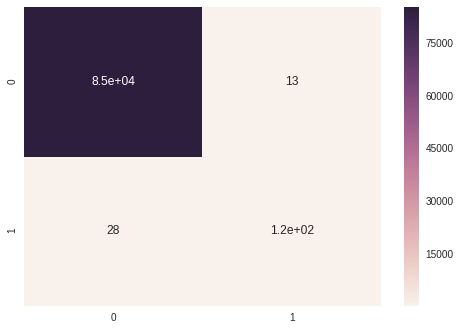

Using Undersampling: 
Mean accuracy score: 0.9681421315044123
Precision: 0.047
Recall: 0.905
Classification Report: 
             precision    recall  f1-score   support

    Class 0       1.00      0.97      0.98     85294
    Class 1       0.05      0.91      0.09       148

avg / total       1.00      0.97      0.98     85442

F1: 0.090



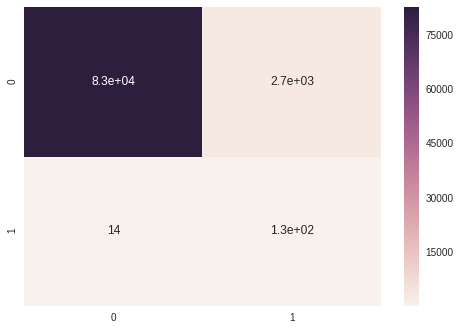

In [0]:
n_estimators = [50, 100, 150, 250, 300]
for n in n_estimators:
  print("Number of trees: ", n)
  print("Using SMOTETomek sampling: ")
  random_forest(x_train, x_test, y_train, y_test, n)
  print("Using Undersampling: ")
  random_forest(x_train_undersampled, x_test, y_train_undersampled, y_test, n)


**A  method to apply logistic regression algorithm on the train data, predict on train data and calculate accuracy**


In [0]:
def logistic_regression(X_train, X_test, y_train, y_test):
    
    penalty = ['l1', 'l2']
    C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    parameters = dict(C=C, penalty=penalty)
    clf = GridSearchCV(LogisticRegression(),parameters)
    best_model = clf.fit(X_train, y_train.values.ravel())
    #print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
    #print('Best C:', best_model.best_estimator_.get_params()['C'])
    prediction =best_model.predict(X_test)
    print("classification_report :  \n ", classification_report(y_test, prediction))
    accuracy = accuracy_score(y_test.values.ravel(), prediction)
    print(f'accuracy: {accuracy}')
    cm = pd.DataFrame(confusion_matrix(y_test, prediction))
    sb.heatmap(cm, annot=True)
    plt.show()

classification_report :  
               precision    recall  f1-score   support

          0       1.00      0.98      0.99     85294
          1       0.06      0.91      0.11       148

avg / total       1.00      0.97      0.99     85442

accuracy: 0.9748952505793403


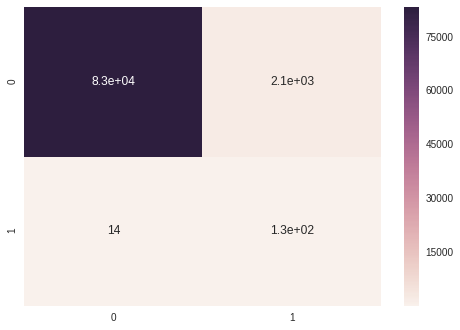

classification_report :  
               precision    recall  f1-score   support

          0       1.00      0.98      0.99     85294
          1       0.07      0.91      0.13       148

avg / total       1.00      0.98      0.99     85442

accuracy: 0.9790384120221904


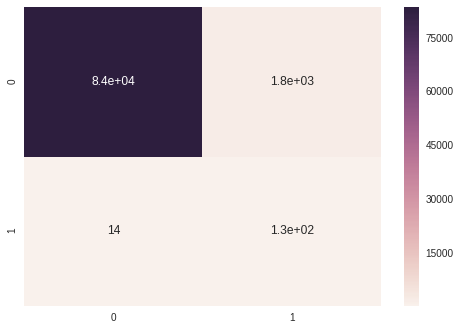

In [0]:
logistic_regression(x_train, x_test, y_train, y_test)
logistic_regression(x_train_undersampled, x_test, y_train_undersampled, y_test)

** Splitting the data **

In [0]:
data = original_data.copy()
print(data.head())

num_transactions = len(data)
num_fraud = sum(data.Class==1)
num_normal = sum(data.Class==0)
outlier = num_fraud/num_transactions
print("Total number of transactions: ", num_transactions)
print("Number of fraud transactions: ", num_fraud)
print("Number of normal transactions: ", num_normal)
print("Number of outliers in all data: ", outlier)

test_data = data[data.Class == 0].sample(frac=0.2)
test_data = pd.concat([test_data, data[data.Class == 1].sample(frac=0.2)])

print("number of normal in test data: ", len(test_data[test_data.Class == 0]))
print("number of fraud in test data: ", len(test_data[test_data.Class == 1]))

train_data = data.drop(test_data.index)

x_train = train_data.iloc[:, data.columns != 'Class']
y_train = train_data.iloc[:, data.columns == 'Class']
x_test = test_data.iloc[:, data.columns != 'Class']
y_test = test_data.iloc[:, data.columns == 'Class']



outliers = len(train_data[train_data.Class == 1]) / len(train_data)
print("Number of outliers in train data: ", outliers)

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V9       V10       V11       V12       V14       V16       V17  \
0  0.363787  0.090794 -0.551600 -0.617801 -0.311169 -0.470401  0.207971   
1 -0.255425 -0.166974  1.612727  1.065235 -0.143772  0.463917 -0.114805   
2 -1.514654  0.207643  0.624501  0.066084 -0.165946 -2.890083  1.109969   
3 -1.387024 -0.054952 -0.226487  0.178228 -0.287924 -1.059647 -0.684093   
4  0.817739  0.753074 -0.822843  0.538196 -1.119670 -0.451449 -0.237033   

        V18       V19       V21  Class  Normalized_Amount  
0  0.025791  0.403993 -0.018307      0

**A method to apply Isolation Forest algorithm on the train data, predict on train data and calculate accuracy**

In [0]:
def isolation_forest(X_train, X_test, Y_test, n): 
  
  isf = IsolationForest(n_estimators=100, max_samples=len(X_train), contamination=n, random_state=0)
  isf.fit(X_train)
  prediction = isf.predict(X_test)   # For each observations, tells inlier or not (+1 or -1)
  prediction[prediction == 1] = 0
  prediction[prediction == -1] = 1
  
  anomaly_score = isf.decision_function(X_test)
  anomaly_score = 0.5 - anomaly_score
  #print("The predicted anomaly score: ", anomaly_score)
  
  plt.hist(anomaly_score, bins=20, label="anomaly score")
  plt.title("Distribution of Anomaly Scores")
  plt.legend()
  plt.show()
  
  print("number of normal in test data: ", len(test_data[test_data.Class == 0]))
  print("number of fraud in test data: ", len(test_data[test_data.Class == 1]))
  
  cm = pd.DataFrame(confusion_matrix(Y_test, prediction))
  #print(cm)
  sb.heatmap(cm, annot=True)
  plt.show()
  
  accuracy = accuracy_score(Y_test, prediction)
  print('accuracy score: ', accuracy)

  precision, recall, fscore, support = score(Y_test, prediction, average='weighted')
  print('precision: ', precision)
  print('recall: ', recall)
  print('f1-score: ', fscore)
  
  auc = roc_auc_score(Y_test, anomaly_score)      # area under ROC curve
  print("\nAUC score: ", auc)    
  
  fpr, tpr, thresholds = roc_curve(Y_test, anomaly_score, pos_label=1)
  auc = np.trapz(tpr, fpr)
  plt.plot(fpr, tpr, label="Isolation Forest AUC=" + str(auc), lw=3, color='C0')
  plt.title("Receiver Operating Characteristic")
  plt.legend()
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()
    
  average_precision = average_precision_score(Y_test, anomaly_score)
  #print('Average precision-recall score: {0:0.2f}'.format(average_precision))
  precision, recall, _ = precision_recall_curve(Y_test, anomaly_score)
  plt.step(recall, precision, color='b', alpha=0.2, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  

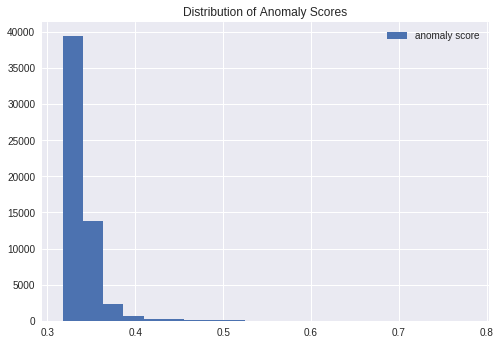

number of normal in test data:  56863
number of fraud in test data:  98


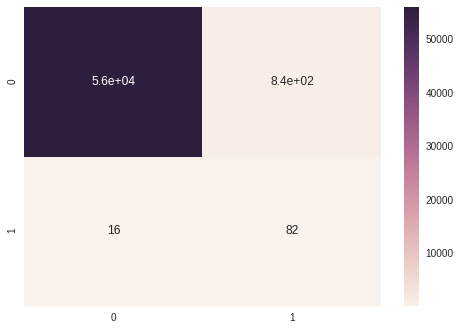

accuracy score:  0.9850599533013816
precision:  0.9981483741944738
recall:  0.9850599533013816
f1-score:  0.991033303645214

AUC score:  0.9489379593703017


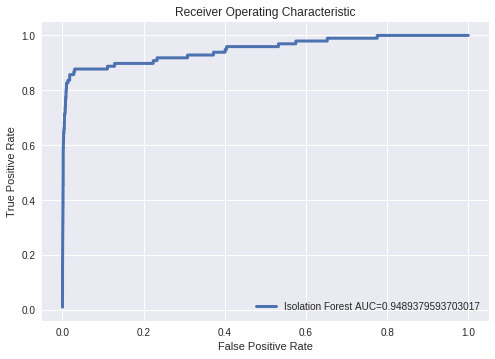

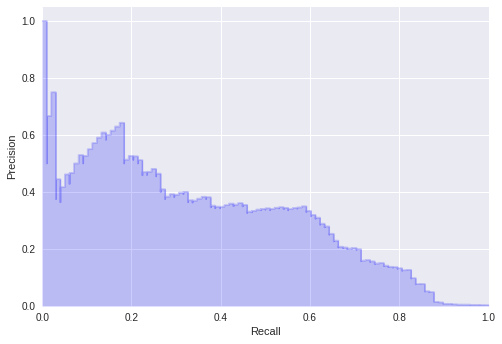

In [0]:
contamination = [0.015]
for n in contamination:
  isolation_forest(x_train, x_test, y_test, n)

In [0]:
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
def local_outlier(X_train, X_test, Y_train, Y_test, n, os):
  
  X = X_train
  n_outliers = len(Y_test.Class == 1)
  ground_truth = np.ones(len(Y_test), dtype=int)
  ground_truth[-n_outliers:] = -1

  clf = LocalOutlierFactor(n_neighbors= n, contamination= os)
  clf.fit(X_train)
  y_pred=clf.fit_predict(X_test)
 
  n_errors = (y_pred != ground_truth).sum()
  X_scores = clf.negative_outlier_factor_
  y_pred[y_pred == 1] = 0
  y_pred[y_pred == -1] = 1

  accuracy = accuracy_score(Y_test, y_pred)
  
  print('accuracy score : ', accuracy)
  print("classification_report :  \n ", classification_report(Y_test, y_pred ))
  
  cm = pd.DataFrame(confusion_matrix(Y_test, y_pred))
  sb.heatmap(cm, annot=True)
  plt.show()
  
 
  precision, recall, fscore, support = score(Y_test, y_pred, average='weighted')
  print('precision: ', precision)
  print('recall: ', recall)
  print('f1-score: ', fscore)

accuracy score :  0.9986657615692517
classification_report :  
               precision    recall  f1-score   support

          0       1.00      1.00      1.00     85294
          1       0.61      0.61      0.61       148

avg / total       1.00      1.00      1.00     85442



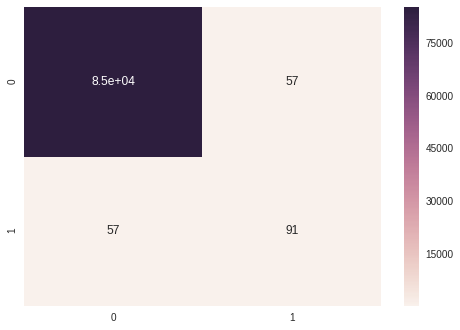

In [0]:
n=200
os=0.001
local_outlier(x_train, x_test, y_train, y_test, n, os)